Epoch 1/25
11745/11745 [==============================] - ETA: 0s - loss: 2.2878
Epoch 1: val_loss improved from inf to 1.53335, saving model to model.h1.MT
11745/11745 [==============================] - 698s 59ms/step - loss: 2.2878 - val_loss: 1.5334
Epoch 2/25
11745/11745 [==============================] - ETA: 0s - loss: 1.4975
Epoch 2: val_loss improved from 1.53335 to 1.48878, saving model to model.h1.MT
11745/11745 [==============================] - 699s 59ms/step - loss: 1.4975 - val_loss: 1.4888
Epoch 3/25
11744/11745 [============================>.] - ETA: 0s - loss: 1.4666
Epoch 3: val_loss improved from 1.48878 to 1.47487, saving model to model.h1.MT
11745/11745 [==============================] - 692s 59ms/step - loss: 1.4665 - val_loss: 1.4749
Epoch 4/25
11745/11745 [==============================] - ETA: 0s - loss: 1.4514
Epoch 4: val_loss improved from 1.47487 to 1.46917, saving model to model.h1.MT
11745/11745 [==============================] - 693s 59ms/step - loss: 1.

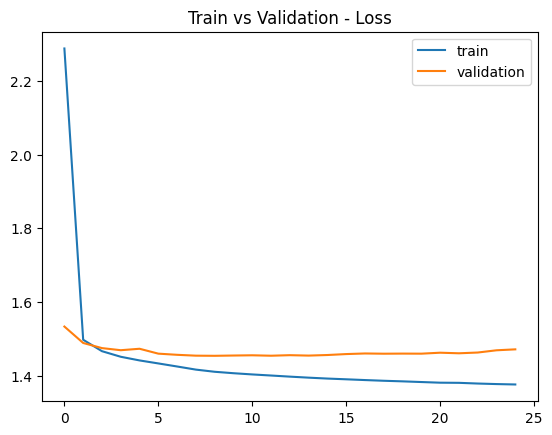

Test Loss: 1.4985
Enter a German sentence: Auf Wiedersehen


NameError: ignored

In [2]:
import collections
from collections import Counter
from keras.models import load_model

import helper
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential, load_model  # Add this line
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, LSTM
from keras.layers import Embedding
from keras.optimizers.legacy import Adam
from keras.losses import sparse_categorical_crossentropy
from keras.callbacks import ModelCheckpoint

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split

from tabulate import tabulate

import gc

# The rest of your code...


# Load parallel corpus
def load_corpus(file_path, encoding='utf-8'):
    try:
        with open(file_path, 'r', encoding=encoding) as file:
            lines = file.read().splitlines()
        return lines
    except UnicodeDecodeError:
        print(f"Error decoding file: {file_path}. Trying with 'latin-1' encoding.")
        return load_corpus(file_path, encoding='latin-1')

# Replace with the actual paths to your downloaded files
german_corpus_path = '/content/train.de'
english_corpus_path = '/content/train.en'

german_corpus = load_corpus(german_corpus_path)
english_corpus = load_corpus(english_corpus_path)

# Tokenization and sequence padding
tokenizer_german = Tokenizer(filters='')
tokenizer_english = Tokenizer(filters='')

tokenizer_german.fit_on_texts(german_corpus)
tokenizer_english.fit_on_texts(english_corpus)

german_sequences = tokenizer_german.texts_to_sequences(german_corpus)
english_sequences = tokenizer_english.texts_to_sequences(english_corpus)

# Pad sequences to the same length
max_length = 50  # Adjust as needed based on your data
padded_german_sequences = pad_sequences(german_sequences, maxlen=max_length, padding='post')
padded_english_sequences = pad_sequences(english_sequences, maxlen=max_length, padding='post')

# Vocabulary size
german_vocab_size = len(tokenizer_german.word_index) + 1
english_vocab_size = len(tokenizer_english.word_index) + 1

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    padded_german_sequences, padded_english_sequences, test_size=0.1, random_state=42
)

# Define the model
def define_model(in_vocab, out_vocab, in_timesteps, out_timesteps, btch_size):
    model = Sequential()
    model.add(Embedding(in_vocab, btch_size, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(btch_size))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(btch_size, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

# Hyperparameters
batch_size = 2
learning_rate = 0.001
epochs = 25
validation_split = 0.1

# Create and compile the model
model = define_model(german_vocab_size, english_vocab_size, max_length, max_length, batch_size)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate))

# Model checkpoint to save the best model
checkpoint_path = 'model.h1.MT'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Training the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, callbacks=[checkpoint], verbose=1)

# Plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'validation'])
plt.title("Train vs Validation - Loss")
plt.show()

# Evaluate the model on test data
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {test_loss:.4f}')

# Load the saved model
model = load_model(checkpoint_path)

# Example translation
# Example translation
def translate_sentence(sentence, german_tokenizer, english_tokenizer, model, max_length):
    sequence = german_tokenizer.texts_to_sequences([sentence])[0]
    sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
    prediction = model.predict(sequence, verbose=0)[0]

    # Find the index of the first occurrence of the padding token
    padding_index = np.argmax(sequence == 0)

    # Consider only the tokens before the padding token
    english_sentence = ' '.join([english_tokenizer.index_word[idx] for idx in np.argmax(prediction[:padding_index], axis=-1) if idx > 0])

    return english_sentence


# Take user input for the German sentence
user_input = input("Enter a German sentence: ")

# Translate the input
translated_output = translate_input(model, user_input, tokenizer_german, tokenizer_english, max_length)

# Display the result
print(f'Translated to English: {translated_output}')